In [4]:
import pandas as pd
import numpy as np
import pathlib  

In [5]:
IN_PARQUET = pathlib.Path("data/40_preprocessed/articles.parquet")

In [41]:
df= pd.read_parquet(IN_PARQUET).sample(n=10000, random_state=42)
df

,title,linked_article_titles,sections_count,categories,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,...,pca_198,pca_199,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,uppercase_word_count,stopword_ratio,punctuation_ratio
333368,sammy guevara,"[aew dynamite, houston, texas, youtube, booker...",5,"[1990 births, Living people, All Elite Wrestli...",2.011980,-0.802128,-0.302151,1.918212,-0.511835,-0.697556,...,0.264642,-0.113063,3586.0,585.0,23.0,5.131624,25.434783,40.0,0.227350,0.058282
104168,woodpecker finch,"[fringillidae, galapagos islands, larva, tongu...",1,"[Finches, Galápagos Islands, Birds of South Am...",1.689718,-0.877276,0.339756,-1.334638,-0.851106,-0.124649,...,-0.137711,-0.094176,482.0,83.0,5.0,4.819277,16.600000,0.0,0.457831,0.029046
59376,"hansell, iowa","[city, iowa, united states]",0,[Cities in Iowa],1.231032,3.135560,4.162294,0.477127,1.038840,-1.171560,...,-0.016565,-0.025544,71.0,13.0,2.0,4.538462,6.500000,0.0,0.461538,0.028169
93235,burkholderia gladioli,"[bacteria, proteobacteria, burkholderia, bacte...",0,[Gram-negative bacteria],1.569686,-0.702369,0.345386,-0.855940,-1.019140,-0.174467,...,0.240731,0.044585,286.0,47.0,4.0,5.106383,11.750000,0.0,0.446809,0.034965
248184,shlomo hillel,"[knesset, baghdad, iraq, jerusalem]",2,"[1923 births, 2021 deaths, Ambassadors of Isra...",2.135104,-0.687185,-0.120917,0.968323,0.121551,1.203299,...,0.047125,-0.070343,873.0,124.0,7.0,6.048387,17.714286,0.0,0.314516,0.041237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107614,the x factor (american tv series),"[reality television, simon cowell, brian fried...",2,"[2011 American television series debuts, 2013 ...",2.142091,-0.545482,-0.276188,1.870808,-0.470467,-0.403202,...,0.088803,0.157536,1324.0,206.0,20.0,5.432039,10.300000,9.0,0.228155,0.036254
320303,the secret of christmas (album),[captain & tennille],0,[],-2.728603,-0.038687,0.090414,1.036594,-0.020878,0.380560,...,0.046050,-0.042164,35.0,4.0,1.0,8.000000,4.000000,1.0,0.000000,0.085714
217821,bamingui-bangoran,"[prefectures of the central african republic, ...",1,[Prefectures of the Central African Republic],1.704473,2.656330,-0.121881,-0.432755,-0.093421,0.113783,...,-0.049406,0.233102,257.0,37.0,4.0,5.972973,9.250000,0.0,0.378378,0.042802
65643,sleep apnea,"[problem, obesity, men, breathing, microsleep,...",7,"[Sleep disorders, Breathing problems]",1.612208,-1.464973,-0.241686,-0.832657,-0.619418,-0.807366,...,0.073032,0.230419,2952.0,451.0,22.0,5.547672,20.500000,3.0,0.354767,0.039295


In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the features for clustering

# Exclude the columns you don't want
features = df.drop(columns=['title', 'linked_article_titles', 'categories'])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

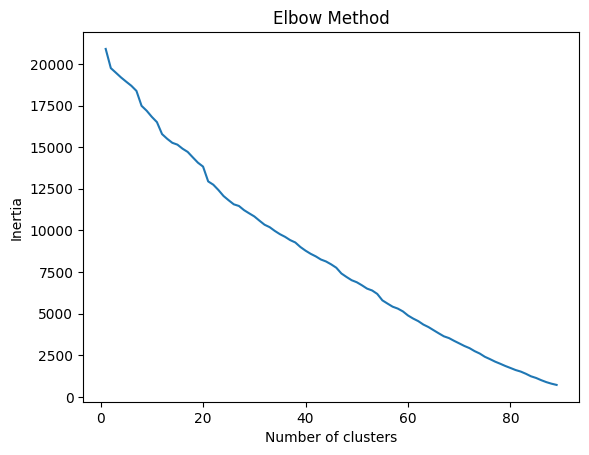

In [32]:
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 90):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 90), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [13]:
df['categories']

0                                                  [Months]
1                                                  [Months]
2         [Art, Non-verbal communication, Basic English ...
3                  [Basic English 850 words, Vowel letters]
4                     [Basic English 850 words, Atmosphere]
                                ...                        
375853                                                   []
375854    [Theodore Roosevelt, Buildings and structures ...
375855          [Warren G. Harding, Presidential libraries]
375856                                                   []
375857                                                   []
Name: categories, Length: 375858, dtype: object

In [15]:
# Flatten all category arrays and get unique values
distinct_categories = set(cat for sublist in df['categories'] for cat in sublist)
print(len(distinct_categories))

66226


In [56]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load your data (assuming it's in a DataFrame `df`)
features = df.drop(columns=['title', 'linked_article_titles', 'categories'])

# Standardize features (crucial for DBSCAN)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Run DBSCAN
dbscan = DBSCAN(eps=10, min_samples=5)  # Adjust hyperparameters
clusters = dbscan.fit_predict(scaled_features)

# Add cluster labels to the original DataFrame
df['cluster'] = clusters

# Analyze results
print("Cluster distribution:")
print(pd.Series(clusters).value_counts())

Cluster distribution:
-1     7716
 0      562
 8      162
 19     161
 13     110
       ... 
 48       5
 57       5
 49       5
 67       4
 71       4
Name: count, Length: 108, dtype: int64


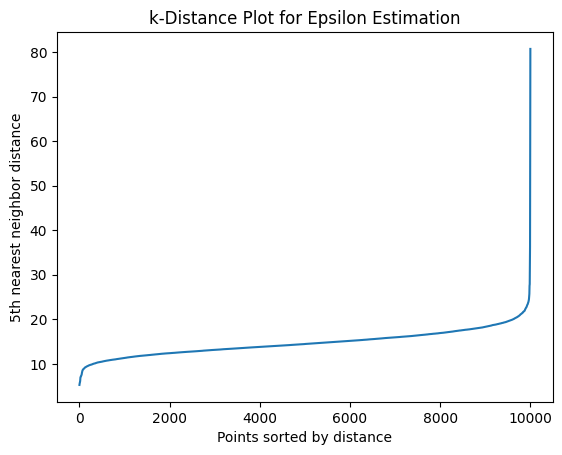

In [48]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

nn = NearestNeighbors(n_neighbors=20)  # k = min_samples
nn.fit(scaled_features)
distances, _ = nn.kneighbors(scaled_features)
distances = np.sort(distances[:, -1])  # Sort the k-th neighbor distances

plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.title('k-Distance Plot for Epsilon Estimation')
plt.show()

In [57]:
from sklearn.metrics import silhouette_score
import numpy as np

# 1. Get cluster labels (assuming you already ran DBSCAN)
clusters = dbscan.labels_  # Array of cluster labels (-1 = noise)

# 2. Filter out noise points (if any)
mask = clusters != -1  # Exclude noise
filtered_data = scaled_features[mask]  # Features without noise
filtered_labels = clusters[mask]  # Labels without noise

# 3. Calculate Silhouette Score (only if >=2 clusters exist)
if len(np.unique(filtered_labels)) >= 2:
    score = silhouette_score(filtered_data, filtered_labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Not enough clusters to compute Silhouette Score.")

Silhouette Score: 0.214
